## Instrucciones generales 

1. Forme un grupo de **máximo tres estudiantes**
1. Versione su trabajo usando un **repositorio <font color="red">privado</font> de github**. Agregue a sus compañeros y a su profesor (usuario github: phuijse) en la pestaña *Settings/Manage access*. No se aceptarán consultas si la tarea no está en github. No se evaluarán tareas que no estén en github.
1. Se evaluará el **resultado, la profundidad de su análisis y la calidad/orden de sus códigos** en base al último commit antes de la fecha y hora de entrega". Se bonificará a quienes muestren un método de trabajo incremental y ordenado según el histórico de *commits*
1. Sean honestos, ríganse por el [código de ética de la ACM](https://www.acm.org/about-acm/code-of-ethics-in-spanish)

# Mi primera Red Neuronal Bayesiana

Las redes neuronales son modelos del estado del arte para hacer regresión y clasificación con datos complejos

Generalmente estos modelos requieren de una gran cantidad de datos para poder entrenarlos de forma efectiva y sin que se sobreajusten. Sin embargo, en algunos problemas los datos disponibles son simplemente muy escasos o muy difíciles de obtener. Adicionalmente, no es directo tomar decisiones en base al modelo, y se requiere un paso adicional de calibración. ¿Cómo podemos confiar en las decisiones del modelo?

Podemos intentar solucionar estos problemas escribiendo la red neuronal como un modelo bayesiano y aprender el posterior de sus parámetros con un método de Markov Chain Monte Carlo (siempre y cuando el modelo sea simple). 

Incorporando priors el modelo estará regularizado y en lugar de estimadores puntuales tendremos la distribución a posteriori completa. Esta rica información extra nos permite medir la confianza del modelo sobre sus predicciones (el modelo sabe cuando no sabe) facilitando la tarea de calibración. 



## Formulación clásica

En esta tarea se pide que programen un modelo de red neuronal para clasificación de datos bidimensionales, de dos clases, con una capa oculta y con función de activación sigmoidal

Sea el conjunto de datos y etiquetas

$$
\mathcal{D} = \{(x, y)^{(i)}, i=1,2,\ldots,N\} \quad x^{(i)} \in \mathbb{R}^2,  y^{(i)} \in \{0, 1\}
$$

Consideremos ahora una tupla en particular $(X, Y)$. La salida de la capa oculta en notación matricial es

$$
Z = \text{sigmoide}( W_Z X + B_Z)
$$

donde $W_Z \in \mathbb{R}^{M \times 2}$, $B_Z \in \mathbb{R}^{M}$ y  $M$ es el tamaño de la capa oculta

La salida de la capa visible (última capa) en notación matricial es

$$
Y = \text{sigmoide}( W_Y Z + B_Y)
$$

donde $W_Y \in \mathbb{R}^{1 \times M}$, $B_Z \in \mathbb{R}$

La función sigmoide se define como

$$
\text{sigmoide}(x) = \frac{1}{1+ e^{-x}}
$$

Luego $Z$ es un vector de largo $M$ con valores en $[0, 1]$ e $Y$ es un escalar con valor en el rango $[0, 1]$

## Formulación bayesiana

Para darle un toque bayesiano a este modelo debemos

- Definir priors para $W_Z$, $B_Z$, $W_Y$ y $B_Y$. Se pide que utilice priors **normales con media cero y desviación estándar diez**.
- Definir una verosimilitud para le problema. Dado que el problema es de clasificación binaria, utilice una distribución de **Bernoulli** con $p=Y$
- Considere los datos $X$ como una variable determínista. 

## Indicaciones

Utilice

- El atributo `shape` para darle la dimensión correcta a cada variable cada uno
- El atributo `observed` para asignar las etiquetas reales a esta variable aleatoria observada
- `pm.Data` para la variable independiente
- `theano.tensor.sigmoid` para calcular la función sigmoide
- `A.dot(B)` para calcular el producto matricial entre `A` y `B`



## Instrucciones específicas

- Considere el dataset sintético `two-moons` que se muestra a continuación. Se pide que realice dos experimentos variando el valor de `n_samples`, primero a $100$ y finalmente a $10$
- Implemente el modelo de red neuronal bayesiana en `pymc3` dejando $M$ como un argumento. Para cada valor de `n_samples` entrene tres modelos con $M=1$, $M=3$ y $M=10$
- Seleccione y calibre un algoritmo de MCMC para entrenar este modelo. Justifique y respalde sus decisiones en base al comportamiento de las trazas, al estadístico Gelman-Rubin y a la función de autocorrelación
- Estudie el posterior de los parámetros y evalue el posterior predictivo sobre los datos de prueba. Muestre graficamente la media y la varianza del posterior predictivo en el espacio de los datos. Haga observaciones y comparaciones entre los 6 casos (3 valores de $M$ y 2 valores de `n_samples`)

# Solucion

In [51]:
import pymc3 as pm
import theano
from theano.tensor.nnet import sigmoid

## Implementacion del modelo (n_samples = 100)

<IPython.core.display.Javascript object>


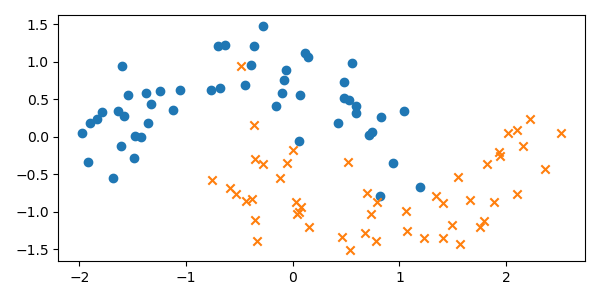

In [52]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_moons

x, y = make_moons(n_samples=100, # Varie este parámetro
                  shuffle=True, noise=0.2, random_state=123456)
x = (x - np.mean(x, keepdims=True))/np.std(x, keepdims=True)

fig, ax = plt.subplots(figsize=(6, 3), tight_layout=True)
ax.scatter(x[y==0, 0], x[y==0, 1], marker='o')
ax.scatter(x[y==1, 0], x[y==1, 1], marker='x')

x1, x2 = np.meshgrid(np.linspace(-3, 3, 100), 
                     np.linspace(-3, 3, 100))
x_test = np.vstack([x1.ravel(), x2.ravel()]).T

In [53]:
def modelrnb(M):
    with pm.Model() as bayes_reg:
        #datos de entrada
        X_shared = pm.Data("x", x).T
        Y_shared = pm.Data("y", y)
        #prioris
        wz = pm.Normal(name='wz', mu=0, sd =10, shape=(M,2))
        bz = pm.Normal(name='bz', mu=0, sd =10, shape=(M,1))
        wy = pm.Normal(name='wy', mu=0, sd =10, shape=(1,M))
        by = pm.Normal(name='by', mu=0, sd =10, shape=(1,1))
        #variable determinista 
        X = pm.Deterministic('X', X_shared)  
        #verosimilitud
        Z = sigmoid(wz.dot(X)+bz)
        Y = sigmoid(wy.dot(Z)+by)
        Y_obs = pm.Bernoulli('Y_obs', p=Y, observed=y)
    return bayes_reg

### Modelo 1 (M = 1)

In [54]:
a100 = modelrnb(1)
a100

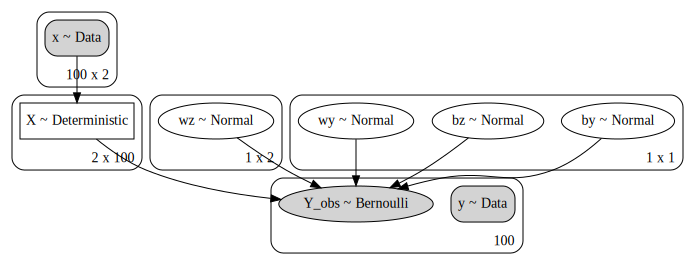

In [57]:
pm.model_to_graphviz(a100)

### Modelo 2 (M = 3)

In [58]:
b100 = modelrnb(3)
b100

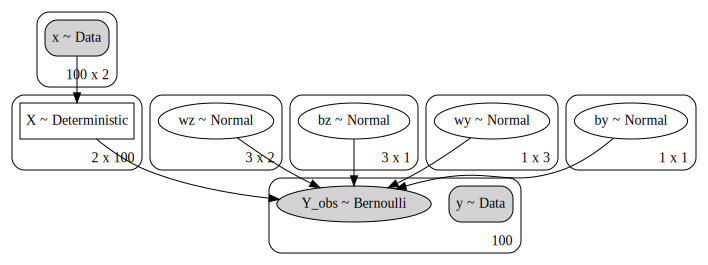

In [59]:
pm.model_to_graphviz(b100)

### Modelo 3 (M = 10)

In [60]:
c100 = modelrnb(10)
c100

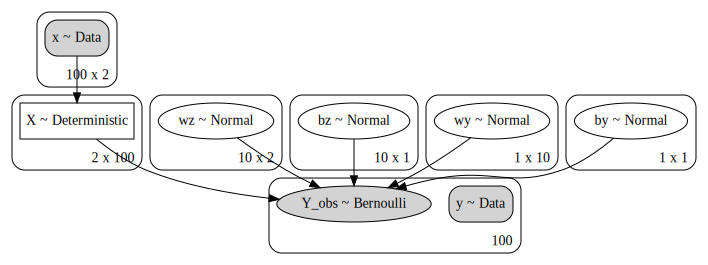

In [61]:
pm.model_to_graphviz(c100)

## Implementacion del modelo (n_samples = 10)

<IPython.core.display.Javascript object>


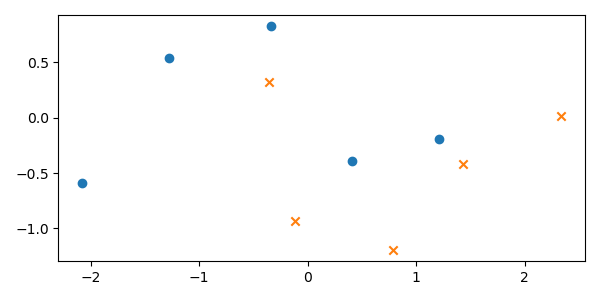

In [62]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_moons

x, y = make_moons(n_samples=10, # Varie este parámetro
                  shuffle=True, noise=0.2, random_state=123456)
x = (x - np.mean(x, keepdims=True))/np.std(x, keepdims=True)

fig, ax = plt.subplots(figsize=(6, 3), tight_layout=True)
ax.scatter(x[y==0, 0], x[y==0, 1], marker='o')
ax.scatter(x[y==1, 0], x[y==1, 1], marker='x')

x1, x2 = np.meshgrid(np.linspace(-3, 3, 100), 
                     np.linspace(-3, 3, 100))
x_test = np.vstack([x1.ravel(), x2.ravel()]).T

### Modelo 1 (M = 1)

In [63]:
a10 = modelrnb(1)
a10

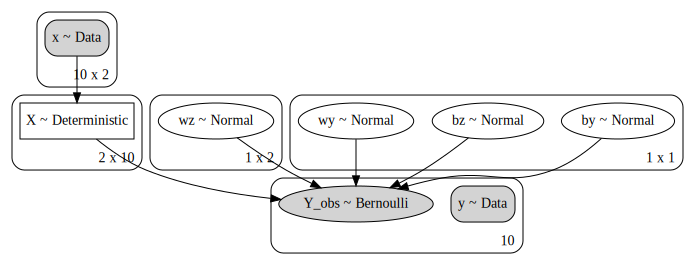

In [64]:
pm.model_to_graphviz(a10)

### Modelo 2 (M = 3)

In [65]:
b10 = modelrnb(3)
b10

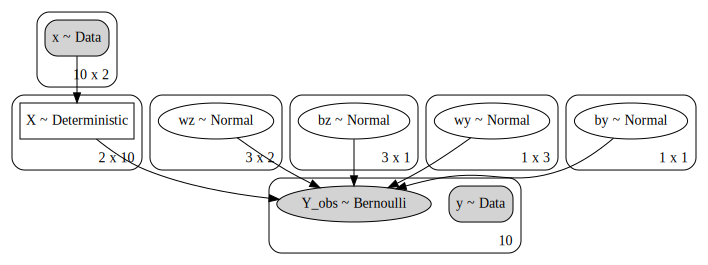

In [66]:
pm.model_to_graphviz(b10)

### Modelo 3 (M = 10)

In [67]:
c10 = modelrnb(10)
c10

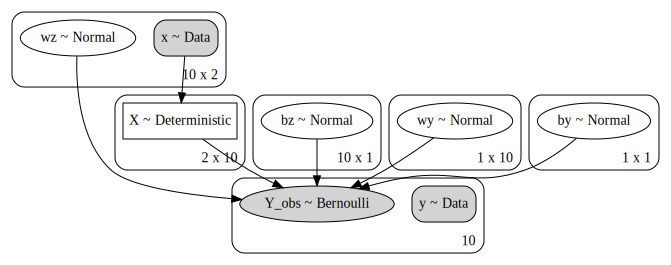

In [68]:
pm.model_to_graphviz(c10)